## Set-up

### Imports

In [1]:
import datetime
import glob
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')  # https://matplotlib.org/users/style_sheets.html
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats
from sklearn import manifold, decomposition, preprocessing
import seaborn as sns
import time

from AlienTask import Task
from shared_aliens import update_Qs_sim, get_alien_paths, get_alien_initial_q,\
    get_summary_initial_learn, get_summary_cloudy, simulate_competition_phase, simulate_rainbow_phase, get_summary_rainbow,\
    read_in_human_data, se

### Switches

In [53]:
# Define things
# run_on_cluster = False
# do_analyze_humans = False
# do_calculate_best_summary = False
# do_calculate_summaries = True
# do_read_in_and_visualize_summaries = True
# do_isomap = False
do_save_selected_agents = True
# if do_analyze_humans:
#     import seaborn as sns
# if do_isomap:
#     from sklearn import manifold, decomposition, preprocessing
# Which model will be simulated?
model_name = 'Bayes'
models = ['flat', 'hier', 'Bayes']
# n_iter = 5000
n_sim_per_subj, n_subj = 1, 29  # n_sim_per_sub = 20, n_subj = 31 (version3.1)  # TODO should be 1, 31-x (1 sim per person; exclude excluded subjects)
n_sim = n_sim_per_subj * n_subj
n_actions, n_aliens, n_seasons, n_TS = 3, 4, 3, 3
alien_initial_Q = get_alien_initial_q(model_name)

In [3]:
# Data paths
## Where is human experimental data stored?
human_data_path = get_alien_paths()["human data prepr"]
## Where will simulated summaries be saved or read in?
plot_dir = os.path.join(get_alien_paths(False)['fitting results'], 'SummariesInsteadOfFitting_revision')
## Where will plots be saved that we create here?
plot_save_dir = os.path.join(plot_dir, 'plots')  # 'C:/Users/maria/MEGAsync/Berkeley/TaskSets/paperplots/'
# now = datetime.datetime.now()
# save_id = '{0}_{1}_{2}_{3}'.format(model_name, param_names, [str(i) for i in np.asarray(param_ranges)], '_'.join([str(i) for i in [now.year, now.month, now.day, now.hour, now.minute]]))

In [4]:
# Allowed parameter ranges to be sampled from
if model_name == 'hier':
    param_names = ['alpha', 'beta', 'forget', 'alpha_high', 'beta_high', 'forget_high']
    param_ranges = pd.DataFrame.from_dict(
        {'alpha': [0, 1], 'beta': [1, 20], 'forget': [0, 1],
         'alpha_high': [0, 1], 'beta_high': [1, 20], 'forget_high': [0, 1]
         })
    
elif model_name == 'flat':
    param_names = ['alpha', 'beta', 'forget']
    param_ranges = pd.DataFrame.from_dict({'alpha': [0, 1], 'beta': [1, 20], 'forget': [0, 1]})
    
elif model_name == 'Bayes':
    param_names = ['alpha', 'beta', 'forget', 'beta_high', 'forget_high']
    param_ranges = pd.DataFrame.from_dict(
        {'alpha': [0, 1], 'beta': [1, 20], 'forget': [0, 1],
         'beta_high': [1, 20], 'forget_high': [0, 1]
         })
    
else:
    raise(NameError, 'model_name must be "flat" or "hier"!')

In [5]:
# Column names for the simulation summary measures
## Initial learning phase
IL_cols = ['IL_saving_av', 'IL_saving_first_trial', 'IL_saving_last_trial',  # savings
           'IL_acc_current_TS', 'IL_acc_prev_TS', 'IL_acc_other_TS',  # intrusion errors
           'IL_acc_current_TS_se', 'IL_acc_prev_TS_se', 'IL_acc_other_TS_se',
           'IL_perf_TS0', 'IL_perf_TS1', 'IL_perf_TS2',  # TS values
           'IL_perf_TS0_se', 'IL_perf_TS1_se', 'IL_perf_TS2_se', 'IL_perf_TS_corr'
           ]
# Cloudy phase
CL_cols = ['CL_acc_trial0', 'CL_acc_trial1', 'CL_acc_trial2', 'CL_acc_trial3',
           'CL_acc_trial0_se', 'CL_acc_trial1_se', 'CL_acc_trial2_se', 'CL_acc_trial3_se',
           'CL_slope', 'CL_slope_TS0', 'CL_slope_TS1', 'CL_slope_TS2']  # TS reactivation
# Competition phase
CO_cols = ['CO_acc_season', 'CO_acc_season_alien', 'CO_acc_season_se', 'CO_acc_season_alien_se']  # competition alien values & TS values
# Rainbow phase
RB_cols = ['RB_alien0_action0', 'RB_alien0_action1', 'RB_alien0_action2',
           'RB_alien1_action0', 'RB_alien1_action1', 'RB_alien1_action2',
           'RB_alien2_action0', 'RB_alien2_action1', 'RB_alien2_action2',
           'RB_alien3_action0', 'RB_alien3_action1', 'RB_alien3_action2']
RB_sum_cols = ['TS0', 'TS1', 'TS2', 'None', 'TS0_se', 'TS1_se', 'TS2_se', 'None_se', 'TS2minusTS0']
summary_dat_cols = param_names + IL_cols + CL_cols + CO_cols[:2] + RB_cols

In [8]:
# Create task, get numbers of trials for each phase
task = Task(n_subj)
n_trials, _, _, _, _ = task.get_trial_sequence(get_alien_paths(False)["human data prepr"],
                                         n_subj, n_sim_per_subj, range(n_subj),
                                         phases=("1InitialLearning", "2CloudySeason"))

n_trials_ = {'1InitialLearn': np.sum(task.phase == '1InitialLearning'),
             '2CloudySeason': np.sum(task.phase == '2CloudySeason'),
             '4RainbowSeason': 4 * n_aliens,
             '5Competition': 3}
trials = {'1InitialLearn': range(n_trials_['1InitialLearn']),
          '2CloudySeason': range(n_trials_['1InitialLearn'],
                                 n_trials_['1InitialLearn'] + n_trials_['2CloudySeason'])}

## Create summaries

In [7]:
# Function to calculate summaries
def get_summary(parameters, param_ranges, n_sim, n_subj, model):

    # Get parmaeters
    ## Scale parameters correctly
    parameters = param_ranges.loc[0] + (param_ranges.loc[1] - param_ranges.loc[0]) * parameters

    beta_shape = (n_sim, 1)  # Q_low_sub.shape -> [n_subj, n_actions]
    beta_high_shape = (n_sim, 1)  # Q_high_sub.shape -> [n_subj, n_TS]
    forget_shape = (n_sim, 1, 1, 1)  # Q_low[0].shape -> [n_subj, n_TS, n_aliens, n_actions]
    forget_high_shape = (n_sim, 1, 1)  # -> [n_subj, n_seasons, n_TS]

    ## Parameters present in all models (flat RL, hier RL, Bayes)
    alpha = parameters['alpha'] * np.ones(n_sim)
    beta = parameters['beta'] * np.ones(beta_shape)
    forget = parameters['forget'] * np.ones(forget_shape)

    ## Parameters present in some models
    try:
        alpha_high = parameters['alpha_high'] * np.ones(n_sim)
    except KeyError:
        alpha_high = np.zeros(n_sim)
    try:
        beta_high = parameters['beta_high'] * np.ones(beta_high_shape)
    except KeyError:
        beta_high = np.zeros(beta_high_shape)
    try:
        forget_high = parameters['forget_high'] * np.ones(forget_high_shape)
    except KeyError:
        forget_high = np.zeros(forget_high_shape)

    # Initial learning phase
    ## Set up data storage
    seasons = np.zeros([n_trials, n_sim], dtype=int)
    corrects = np.zeros([n_trials, n_sim])
    rewards = np.zeros([n_trials, n_sim])
    aliens = np.zeros([n_trials, n_sim], dtype=int)
    actions = np.zeros([n_trials, n_sim], dtype=int)

    ## Inialize Q-values
    Q_low = alien_initial_Q * np.ones([n_sim, n_TS, n_aliens, n_actions])
    Q_high = alien_initial_Q * np.ones([n_sim, n_seasons, n_TS])

    ## Simulate behavior
    for trial in trials['1InitialLearn']:

        ### Observe stimuli
        season, alien = task.present_stimulus(trial)

        ### Select action & update Q-values
        [Q_low, Q_high, TS, action, correct, reward, p_low] =\
            update_Qs_sim(season, alien,
                          Q_low, Q_high,
                          beta, beta_high, alpha, alpha_high, forget, forget_high,
                          n_sim, n_actions, n_TS, task, alien_initial_Q, model_name)

        ### Store trial data
        seasons[trial] = season
        corrects[trial] = correct
        rewards[trial] = reward
        aliens[trial] = alien
        actions[trial] = action

    ## Save final Q-values for subsequent phases
    final_Q_low = Q_low.copy()
    final_Q_high = Q_high.copy()

    ## Calculate summaries for initial learning phase
    summary_initial_learn = get_summary_initial_learn(
        seasons[trials['1InitialLearn']], corrects[trials['1InitialLearn']],
        aliens[trials['1InitialLearn']], actions[trials['1InitialLearn']],
        n_seasons, n_sim, trials, task)

    # Cloudy season
    for trial in trials['2CloudySeason']:

        ## Observe trial stimuli
        old_season = season.copy()
        season, alien = task.present_stimulus(trial)

        ## Season switches
        if trial == list(trials['2CloudySeason'])[0]:
            season_switches = np.ones(n_sim, dtype=bool)
        else:
            season_switches = season != old_season

        if (model_name == 'hier') or (model_name == 'Bayes'):
            Q_high[season_switches] = alien_initial_Q  # re-start search for the right TS when season changes
        elif model_name == 'flat':
            Q_low[season_switches] = alien_initial_Q  # re-learn a new policy from scratch when season changes
        else:
            raise(NameError, 'Model_name must be "flat", "hier", or "Bayes".')

        ## Update Q-values
        [Q_low, Q_high, TS, action, correct, reward, p_low] =\
            update_Qs_sim(0 * season, alien,
                          Q_low, Q_high,
                          beta, beta_high, alpha, alpha_high, forget, forget_high,
                          n_sim, n_actions, n_TS, task, alien_initial_Q, model_name)

        ## Store trial data
        seasons[trial] = season
        corrects[trial] = correct

    ## Calculate summaries for cloudy phase
    summary_cloudy = get_summary_cloudy(seasons, corrects, n_sim, trials['2CloudySeason'])

    # Run and get summaries for competition phase
    comp_data = simulate_competition_phase(model_name, final_Q_high, final_Q_low, task,
                                           n_seasons, n_aliens, n_sim, beta_high, n_blocks_comp=n_trials_['5Competition'])
    summary_competition = comp_data.groupby('phase').aggregate('mean')['perc_selected_better'].values

    # Run and get summaries for rainbow season
    rainbow_dat = simulate_rainbow_phase(n_seasons, model_name, n_sim,
                                         beta, beta_high, final_Q_low, final_Q_high)

    # Return list of summaries  # TODO would be better as pd.DataFrame, dict, etc.
    return list(parameters.values) + summary_initial_learn + list(summary_cloudy) + list(summary_competition) + list(rainbow_dat.flatten())

In [9]:
save_frequency = 100
print_frequency = 100
n_frames = 20
n_sims_per_frame = 1000

# Get summaries for different parameters
new_time = time.time()

for frame_i in range(n_frames):
    summaries = pd.DataFrame(
        np.full((n_sims_per_frame, 1 + len(summary_dat_cols)), np.nan),
        columns=summary_dat_cols + ['model'])
    summaries['model'] = model_name

    for sim_i in range(n_sims_per_frame):
        params = np.random.rand(len(param_names))
        summaries.loc[sim_i, :-1] = get_summary(params, param_ranges, n_sim, n_subj, model_name)

        if (sim_i % print_frequency) == 0:

            # Print progress
            print("\n\tIteration {}".format(sim_i))
            old_time = new_time
            new_time = time.time()
            diff = new_time - old_time
            print("Time passed: {} seconds".format(np.round(diff)))
            print(summaries.agg('mean'))

        if ((sim_i % save_frequency) == 0) or (sim_i == n_sims_per_frame - 1):

            # Save summaries to disk
            save_path = os.path.join(plot_dir, model_name + '_summaries0_{}.csv'.format(frame_i))
            summaries.to_csv(save_path)
            print("Saving summaries to {}".format(save_path))


	Iteration 0
Time passed: 2.0 seconds
alpha                     0.883440
beta                      1.162023
forget                    0.905209
beta_high                14.792712
forget_high               0.080174
IL_saving_av              0.016578
IL_saving_first_trial     0.045977
IL_saving_last_trial     -0.103448
IL_acc_current_TS         0.334975
IL_acc_prev_TS            0.349754
IL_acc_other_TS           0.320197
IL_acc_current_TS_se      0.032880
IL_acc_prev_TS_se         0.030831
IL_acc_other_TS_se        0.031662
IL_perf_TS0               0.331123
IL_perf_TS1               0.339080
IL_perf_TS2               0.335102
IL_perf_TS0_se            0.014028
IL_perf_TS1_se            0.011766
IL_perf_TS2_se            0.012273
IL_perf_TS_corr           0.500000
CL_acc_trial0             0.333333
CL_acc_trial1             0.314176
CL_acc_trial2             0.340996
CL_acc_trial3             0.298851
CL_acc_trial0_se          0.028672
CL_acc_trial1_se          0.032990
CL_acc_trial2_se

KeyboardInterrupt: 

## Read in simulation summaries and vizualize as density plots

In [6]:
# Get human data
n_hum, hum_aliens, hum_seasons, hum_corrects, hum_actions, hum_rewards, hum_rainbow_dat, hum_comp_dat = read_in_human_data(
    human_data_path, 828, n_aliens, n_actions, exclude=['160', '164'])

Reading in human data from C:/Users/maria/MEGAsync/Berkeley/TaskSets/Data/version3.1preprocessed/!
2 subjects were exlcuded: ['160', '164']


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
# Get human initial learn data
hum_summary_initial_learn = get_summary_initial_learn(hum_seasons[trials['1InitialLearn']], hum_corrects[trials['1InitialLearn']], hum_aliens[trials['1InitialLearn']], hum_actions[trials['1InitialLearn']],
                                                      n_seasons, n_hum, trials, task)
hum_summary_initial_learn = pd.DataFrame(np.expand_dims(np.array(hum_summary_initial_learn), axis=0),
                                         columns=IL_cols)

hum_summary_initial_learn['IL_saving_last_minus_first'] = hum_summary_initial_learn['IL_saving_last_trial'] - hum_summary_initial_learn['IL_saving_first_trial']
hum_summary_initial_learn['IL_perf_TS2minus1'] = hum_summary_initial_learn['IL_perf_TS2'] - hum_summary_initial_learn['IL_perf_TS1']

# Get human cloudy data
hum_summary_cloudy = get_summary_cloudy(hum_seasons, hum_corrects, n_hum, trials['2CloudySeason'])
hum_summary_cloudy = pd.DataFrame(np.expand_dims(np.array(hum_summary_cloudy), axis=0),
                                  columns=CL_cols)

# Get human competition data
season_cols = [col for col in hum_comp_dat.columns.values if col[0] == "("]
alien_cols = [col for col in hum_comp_dat.columns.values if col[0] != "("]
season_perf = np.mean(hum_comp_dat[season_cols], axis=1)
alien_perf = np.mean(hum_comp_dat[alien_cols], axis=1)
season_mean = np.mean(season_perf)
season_se = np.std(season_perf) / np.sqrt(n_hum)
alien_mean = np.mean(alien_perf)
alien_se = np.std(alien_perf) / np.sqrt(n_hum)
comp_t, comp_p = stats.ttest_rel(season_perf, alien_perf)
hum_summary_competition = pd.DataFrame(np.array([[season_mean, alien_mean, season_se, alien_se, np.mean(season_perf-alien_perf)]]),
                                       columns=CO_cols + ['CO_season_minus_alien'])

# Get human rainbow data
# hum_rainbow_dat = pd.DataFrame(np.expand_dims(hum_rainbow_dat.flatten(), axis=0), columns=RB_cols)
hum_summary_rainbow = get_summary_rainbow(n_aliens, n_seasons, hum_rainbow_dat, task)
hum_summary_rainbow = pd.DataFrame(np.expand_dims(hum_summary_rainbow, axis=0),
                                   columns=RB_sum_cols)
hum_summary_rainbow['TS2minusTS1'] = hum_summary_rainbow['TS2'] - hum_summary_rainbow['TS1']
hum_summary_rainbow.head()

,TS0,TS1,TS2,None,TS0_se,TS1_se,TS2_se,None_se,TS2minusTS0,TS2minusTS1
0,0.360153,0.316092,0.284483,0.122126,0.053946,0.05501,0.056284,0.021828,-0.07567,-0.031609


In [39]:
# Get agent summary filenames
filenames = glob.glob(os.path.join(plot_dir, '*.csv'))
filenames = [filename for filename in filenames if 'summar' in filename]  # don't read in selected_agents.csv etc.
print('Reading in {} files.'.format(len(filenames)))

Reading in 120 files.


In [40]:
all_summaries = pd.DataFrame(columns=param_names)
for filename in filenames:
    summaries = pd.read_csv(filename, index_col=0)
    summaries = summaries.dropna()  # remove empty rows
    all_summaries = all_summaries.append(summaries)
all_summaries = all_summaries.reset_index(drop=True)

# # Add model column (flat or hier)
# all_summaries['model'] = 'hier'
# all_summaries.loc[all_summaries.isnull()['alpha_high'], 'model'] = 'flat'
# all_summaries.loc[all_summaries.isnull()['forget_high'], 'model'] = 'Bayes'

# Add other measures
all_summaries['IL_saving_last_minus_first'] = all_summaries['IL_saving_last_trial'] - all_summaries['IL_saving_first_trial']
all_summaries['IL_perf_TS2minus1'] = all_summaries['IL_perf_TS2'] - all_summaries['IL_perf_TS1']
all_summaries['CO_season_minus_alien'] = all_summaries['CO_acc_season'] - all_summaries['CO_acc_season_alien']

print("Number of samples: {} (flat: {}; hier: {}; Bayes: {})".
      format(all_summaries.shape[0],
             np.sum(all_summaries['model'] == 'flat'),
             np.sum(all_summaries['model'] == 'hier'),
             np.sum(all_summaries['model'] == 'Bayes')
))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Number of samples: 118999 (flat: 39999; hier: 39999; Bayes: 39001)


In [41]:
# Get rainbow summary
summary_rainbow = pd.DataFrame()
for model in models:
    rainbow_dat = all_summaries.loc[all_summaries['model'] == model, RB_cols]
    rainbow_dat = rainbow_dat.values.reshape((rainbow_dat.shape[0], n_aliens, n_actions))
    summary_rainbow_mod = np.array([get_summary_rainbow(n_aliens, n_seasons, dat, task) for dat in rainbow_dat])
    summary_rainbow_mod = pd.DataFrame(summary_rainbow_mod, columns=RB_sum_cols)
    summary_rainbow_mod.loc[:, 'model'] = model
    cor = np.array([np.corrcoef(hum_rainbow_dat[0].flatten(), dat.flatten())[0, 1] for dat in rainbow_dat.astype(float)])
    summary_rainbow_mod.loc[:, 'corr_with_humans'] = cor
    summary_rainbow = summary_rainbow.append(summary_rainbow_mod)
summary_rainbow.head()

,TS0,TS1,TS2,None,TS0_se,TS1_se,TS2_se,None_se,TS2minusTS0,model,corr_with_humans
0,0.348677,0.349743,0.284683,0.133807,0.0,0.0,0.0,0.0,-0.063994,flat,0.880654
1,0.342684,0.353657,0.289172,0.140298,0.0,0.0,0.0,0.0,-0.053512,flat,0.803316
2,0.340301,0.344850,0.319267,0.152595,0.0,0.0,0.0,0.0,-0.021035,flat,0.689632
3,0.340247,0.339315,0.304609,0.149399,0.0,0.0,0.0,0.0,-0.035638,flat,0.920848
4,0.334448,0.333681,0.331417,0.165620,0.0,0.0,0.0,0.0,-0.003031,flat,0.858715


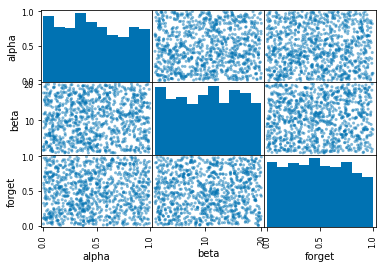

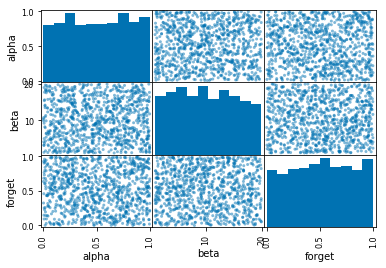

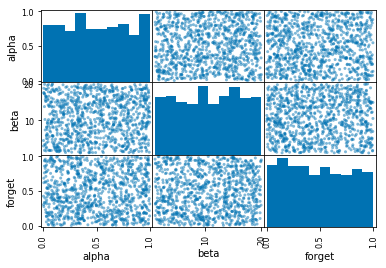

In [42]:
# Plot correlations and histograms
for model_name in models:
    model_summaries = all_summaries.loc[all_summaries['model'] == model_name]
    model_summaries = model_summaries.reset_index(drop=True)
    pd.plotting.scatter_matrix(model_summaries.loc[:1000, ['alpha', 'beta', 'forget']])

In [43]:
# Reusable histogram function for all histogram plots
def make_histogram(sim_dat, hum_dat, columns,
                   xlabels=False, ylabel="Density", xlim=False, ylim=False, vline=False, yscale_log=False, scale_data=1, plot_name=''):
    nrows = max(len(columns), 2)
    fig, axes = plt.subplots(nrows=nrows, figsize=(6, nrows * 2))
    [ax.set_ylabel(ylabel) for ax in axes]
    if not xlabels:
        xlabels = columns
    for i, (effect, xlabel) in enumerate(zip(columns, xlabels)):
        for model in models:
            dat = sim_dat.loc[sim_dat['model'] == model]
            sns.distplot(scale_data*dat[effect], kde=True, hist=True, label=model, ax=axes[i])
        if np.any(hum_dat):
            axes[i].axvline(x=scale_data*hum_dat[effect].values, color='tomato', linestyle='-')
        axes[i].set_xlabel(xlabel)
    if vline:
        [ax.axvline(x=vline, color='grey', linestyle='--') for ax in axes]
    if xlim:
        [ax.set_xlim(xlim) for ax in axes]
    if ylim:
        [ax.set_ylim(ylim) for ax in axes]
    if yscale_log:
        [ax.set_yscale('log') for ax in axes]
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(plot_save_dir, plot_name))

def get_means_sds(sim_dat, hum_dat, column, t_compare_value=0):
    means_sds = sim_dat.groupby("model")[column].agg(
        {'mean': 'mean',
         'std': 'std',
         'lik': lambda x: np.mean(x > hum_dat[column][0]),
         'lik2': lambda x: np.mean(x < hum_dat[column][0])})
    ttests = sim_dat.groupby('model')[column].agg(stats.ttest_1samp, t_compare_value)
    return means_sds, ttests

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


(           mean       std       lik      lik2
 model                                        
 Bayes  0.009897  0.066643  0.037486  0.962257
 flat  -0.000135  0.065079  0.024951  0.974899
 hier   0.032190  0.080907  0.078402  0.921173, model
 Bayes    (29.32834061240505, 4.889664765858972e-187)
 flat      (-0.41565240075397347, 0.6776666063892478)
 hier                        (79.57284705058481, 0.0)
 Name: CL_slope, dtype: object)

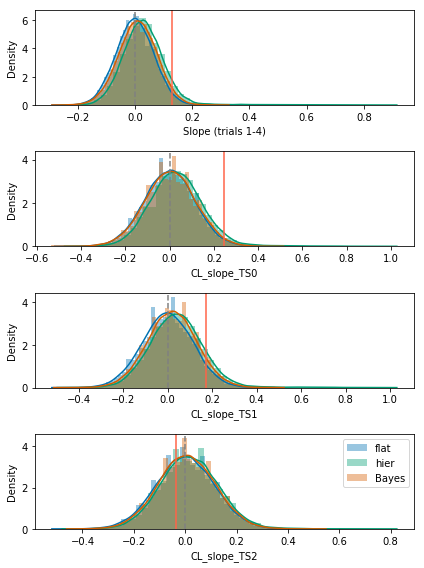

In [44]:
# Reactivation of TS (cloudy)
make_histogram(all_summaries, hum_summary_cloudy, CL_cols[8:],
               plot_name='0TS_react_hist.png',
               xlabels=['Slope (trials 1-4)'] + CL_cols[9:], vline=1e-10, yscale_log=False)
# make_histogram(all_summaries, hum_summary_cloudy, CL_cols[8:],
#                plot_name='0TS_react_hist_log.png',
#                xlabels=['Slope (trials 1-4)'] + CL_cols[9:], vline=1e-10, yscale_log=True)
get_means_sds(all_summaries, hum_summary_cloudy, 'CL_slope')

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


(           mean       std       lik      lik2
model                                        
Bayes  0.315320  0.037859  0.586831  0.364786
flat   0.355183  0.092516  0.801320  0.160679
hier   0.307816  0.040967  0.490737  0.459736, model
Bayes     (-93.96657071134486, 0.0)
flat       (47.23417133872234, 0.0)
hier     (-124.57419192802557, 0.0)
Name: IL_acc_current_TS, dtype: object)
(           mean       std       lik      lik2
model                                        
Bayes  0.414620  0.104807  0.419605  0.580395
flat   0.329798  0.036673  0.027451  0.972549
hier   0.443565  0.095806  0.607465  0.392535, model
Bayes                        (153.16668187599976, 0.0)
flat     (-19.279682842724743, 1.8856261270879158e-82)
hier                         (230.11173939085327, 0.0)
Name: IL_acc_prev_TS, dtype: object)


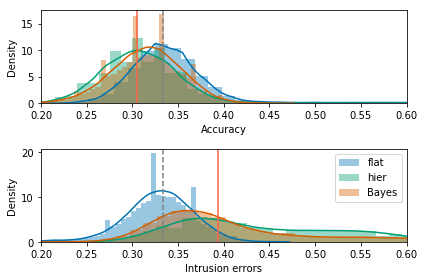

In [45]:
# Intrusion errors (init. learn.)
make_histogram(all_summaries, hum_summary_initial_learn, IL_cols[3:5],
               plot_name='1intrusion_errors_hist.png',
               xlim=(0.2, 0.6), xlabels=['Accuracy', 'Intrusion errors'], vline=1/3)
print(get_means_sds(all_summaries, hum_summary_initial_learn, IL_cols[3], 1/3))
print(get_means_sds(all_summaries, hum_summary_initial_learn, IL_cols[4], 1/3))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


(           mean       std       lik      lik2
model                                        
Bayes  0.007432  0.025493  0.917002  0.082716
flat  -0.000929  0.015854  0.862197  0.137128
hier  -0.009042  0.026541  0.697717  0.301783, model
Bayes                        (57.57316778563306, 0.0)
flat     (-11.71714318175947, 1.1731189168343807e-31)
hier                          (-68.136467310256, 0.0)
Name: IL_perf_TS2minus1, dtype: object)


No handles with labels found to put in legend.


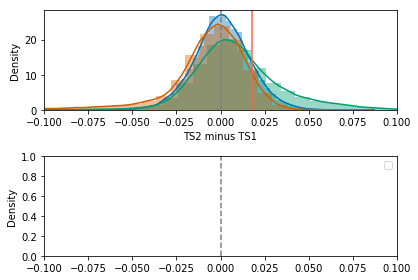

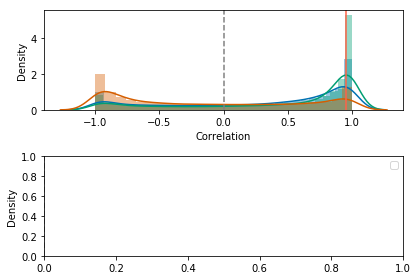

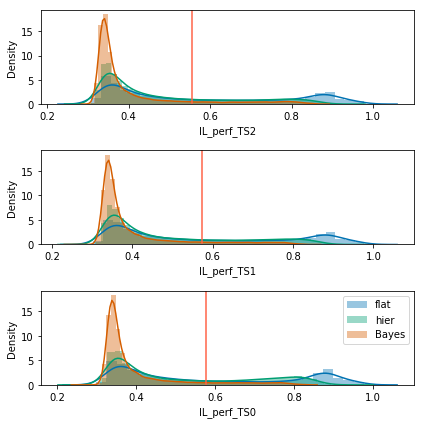

In [46]:
# TS values affect performance (init. learn.)
make_histogram(all_summaries, hum_summary_initial_learn, ['IL_perf_TS2minus1'],
               plot_name='2TS_values_perf_hist.png',
               xlim=(-0.1, 0.1), xlabels=['TS2 minus TS1'], vline=1e-10, scale_data=-1)
print(get_means_sds(all_summaries, hum_summary_initial_learn, 'IL_perf_TS2minus1'))
make_histogram(all_summaries, hum_summary_initial_learn, [IL_cols[-1]],
               plot_name='2TS_values_perf_hist2.png',
               xlabels=['Correlation'], vline=1e-10, scale_data=-1)
make_histogram(all_summaries, hum_summary_initial_learn, IL_cols[9:12][::-1], plot_name='2TS_values_perf_hist3.png')  # TS perf (init. learn.)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


(           mean       std       lik      lik2
 model                                        
 Bayes  0.039596  0.039103  0.383580  0.616420
 flat  -0.045695  0.066359  0.020351  0.979649
 hier   0.044144  0.045057  0.405110  0.594890, model
 Bayes     (199.97716187268884, 0.0)
 flat     (-137.71783357870396, 0.0)
 hier      (195.94660771445268, 0.0)
 Name: CO_season_minus_alien, dtype: object)

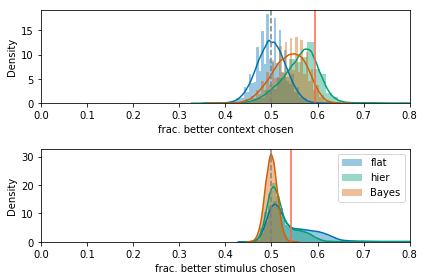

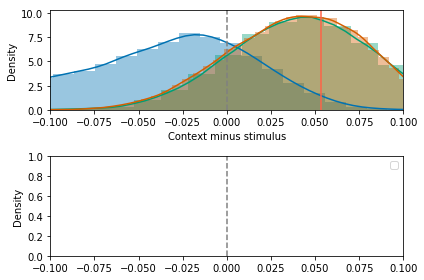

In [47]:
# TS values affect preference (competition)
make_histogram(all_summaries, hum_summary_competition, CO_cols[:2],
               plot_name='3TS_values_preference_hist.png',
               xlim=(0, 0.8), xlabels=['frac. better context chosen', 'frac. better stimulus chosen'], vline=1/2)
make_histogram(all_summaries, hum_summary_competition, ['CO_season_minus_alien'],
               plot_name='3TS_values_preference_hist2.png',
               xlim=(-0.1, 0.1), xlabels=['Context minus stimulus'], vline=1e-10)
get_means_sds(all_summaries, hum_summary_competition, 'CO_season_minus_alien')

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


(           mean       std       lik      lik2
 model                                        
 Bayes -0.042473  0.063433  0.820876  0.179124
 flat  -0.036658  0.040836  0.810695  0.189305
 hier  -0.130385  0.106437  0.448836  0.551164, model
 Bayes    (-132.23092930924614, 0.0)
 flat      (-179.5339189034364, 0.0)
 hier     (-244.99446638175786, 0.0)
 Name: TS2minusTS0, dtype: object)

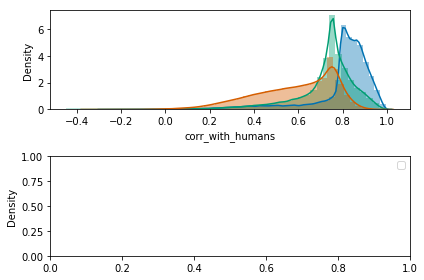

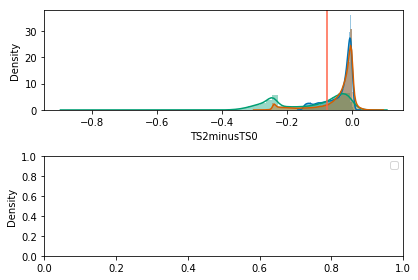

In [48]:
# TS values affect generalization (rainbow)
summary_rainbow['TS2minusTS0'] = summary_rainbow['TS2'] - summary_rainbow['TS0']
make_histogram(summary_rainbow, hum_dat=False, columns=['corr_with_humans'],
               plot_name='4TS_values_generalization_hist.png')
make_histogram(summary_rainbow, hum_dat=hum_summary_rainbow, columns=['TS2minusTS0'],
               plot_name='4TS_values_generalization_hist_.png')
get_means_sds(summary_rainbow, hum_summary_rainbow, 'TS2minusTS0')

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


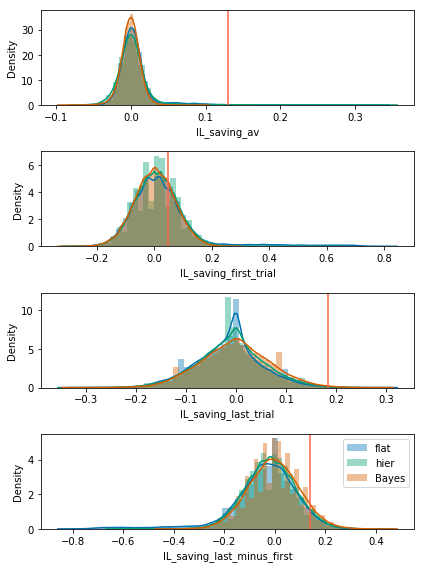

In [49]:
# Savings (init. learn.)
make_histogram(all_summaries,
               hum_summary_initial_learn, IL_cols[:3] + ['IL_saving_last_minus_first'],
               plot_name='5Savings_hist.png')

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


(           mean       std       lik      lik2
 model                                        
 Bayes -0.042473  0.063433  0.820876  0.179124
 flat  -0.036658  0.040836  0.810695  0.189305
 hier  -0.130385  0.106437  0.448836  0.551164, model
 Bayes    (-132.23092930924614, 0.0)
 flat      (-179.5339189034364, 0.0)
 hier     (-244.99446638175786, 0.0)
 Name: TS2minusTS0, dtype: object)

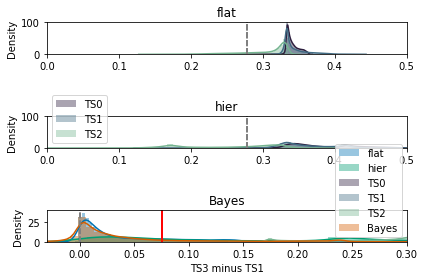

In [50]:
# TS values affect generalization (rainbow)
fig, axes = plt.subplots(nrows=3)
colors = sns.cubehelix_palette(4, start=.5, rot=-.75, reverse=True)[:-1]

for i, model in enumerate(models):
    dat = summary_rainbow.loc[summary_rainbow['model'] == model]

    # Plot
    for j, effect in enumerate(RB_sum_cols[:3]):
        sns.distplot(dat[effect], kde=True, hist=True, label=effect, color=colors[j], ax=axes[i])
        [ax.axvline(x=10/12/3, color='grey', linestyle='--') for ax in axes[:2]]
        [ax.set_xlim(0, 0.5) for ax in axes[:2]]
        [ax.set_ylim(0, 100) for ax in axes[:2]]
        axes[i].set_title(model)
        [ax.set_xlabel("") for ax in axes]
        axes[1].legend()

    effect = 'TS2minusTS0'
    sns.distplot(-dat[effect], kde=True, hist=True, label=model, ax=axes[2])
    axes[2].axvline(x=0, color='grey', linestyle='--')
    axes[2].axvline(x=-hum_summary_rainbow[effect].values, color='red', linestyle='-')
    axes[2].set_xlim(-0.03, 0.3)
    axes[2].set_ylim(0, 40)
    axes[2].set_xlabel("TS3 minus TS1")
    axes[2].legend()
[ax.set_ylabel("Density") for ax in axes]
plt.tight_layout()
plt.savefig(plot_save_dir + '/4TS_values_generalization_hist2.png')
get_means_sds(summary_rainbow, hum_summary_rainbow, 'TS2minusTS0')

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDe

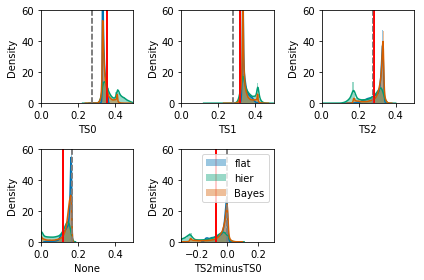

In [51]:
# Rainbow phase TS choices
plt.figure()
for model in models:

    # Get summary_rainbow
    rainbow_dat = all_summaries.loc[all_summaries['model'] == model, RB_cols]
    rainbow_dat = rainbow_dat.values.reshape((rainbow_dat.shape[0], n_aliens, n_actions))
    summary_rainbow = np.array([get_summary_rainbow(n_aliens, n_seasons, dat, task) for dat in rainbow_dat])
    summary_rainbow = pd.DataFrame(summary_rainbow, columns=RB_sum_cols)

    # Plot
    for i, effect in enumerate(RB_sum_cols[:3]):
        plt.subplot(2, 3, i+1)
        sns.distplot(summary_rainbow[effect], kde=True, hist=True, label=model)
        plt.axvline(x=10/12/3, color='grey', linestyle='--')
        plt.axvline(x=hum_summary_rainbow[effect].values, color='red', linestyle='-')
        plt.xlim(0, 0.5)
        plt.ylim(0, 60)
        plt.xlabel(effect)
        plt.ylabel("Density")

    effect = RB_sum_cols[3]
    plt.subplot(2, 3, 4)
    sns.distplot(summary_rainbow[effect], kde=True, hist=True, label=model)
    plt.axvline(x=(2/12), color='grey', linestyle='--')
    plt.axvline(x=hum_summary_rainbow[effect].values, color='red', linestyle='-')
    plt.xlim(0, 0.5)
    plt.ylim(0, 60)
    plt.xlabel(effect)
    plt.ylabel("Density")

    effect = 'TS2minusTS0'
    plt.subplot(2, 3, 5)
    sns.distplot(summary_rainbow[effect], kde=True, hist=True, label=model)
    plt.axvline(x=0, color='grey', linestyle='--')
    plt.axvline(x=hum_summary_rainbow[effect].values, color='red', linestyle='-')
    plt.xlim(-0.3, 0.3)
    plt.ylim(0, 60)
    plt.xlabel(effect)
    plt.ylabel("Density")

plt.legend()
plt.tight_layout()

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

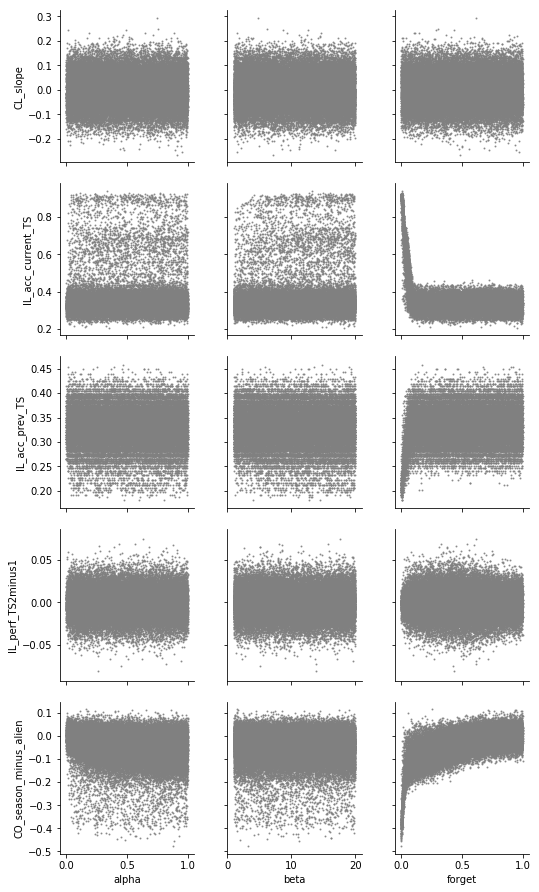

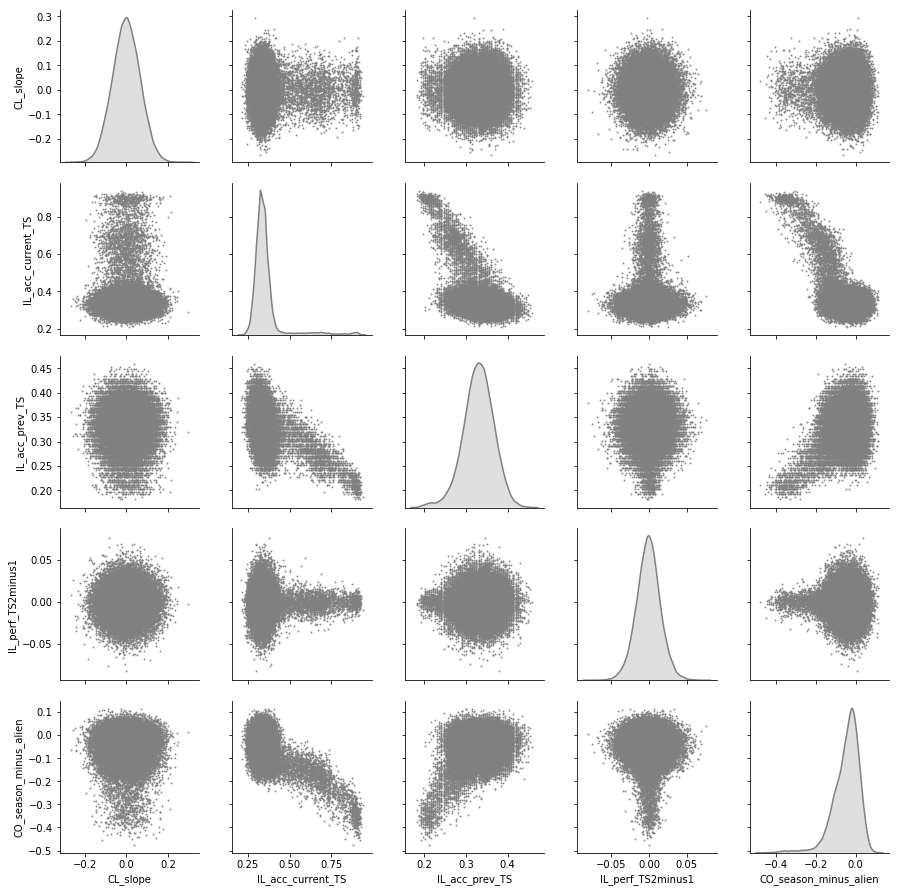

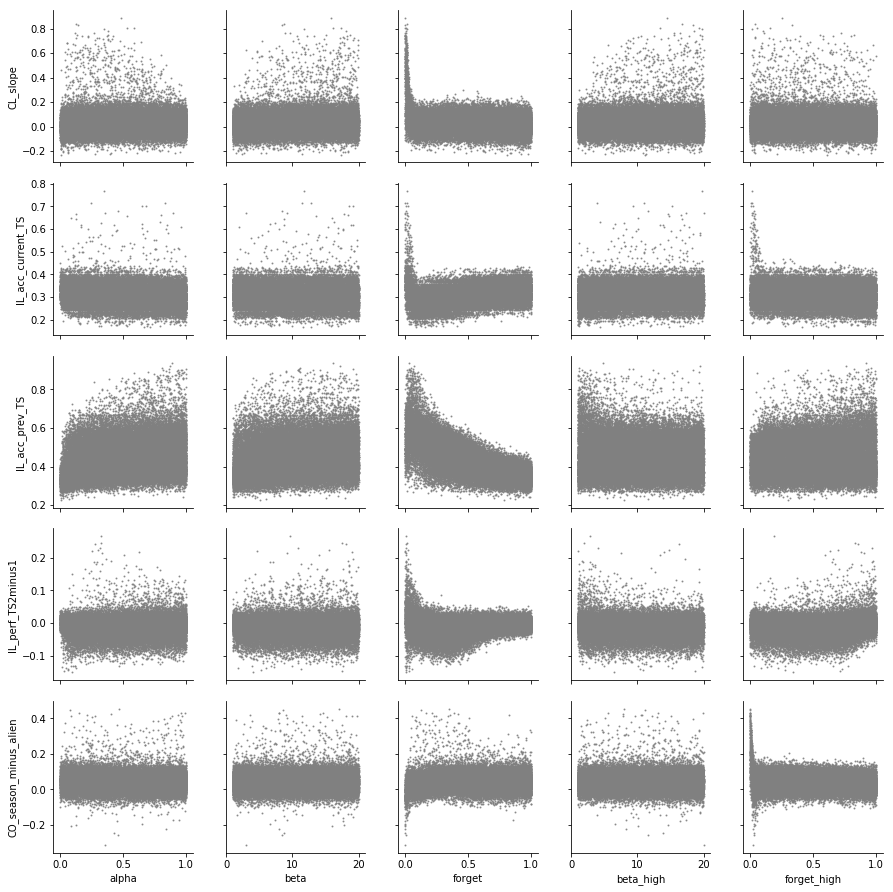

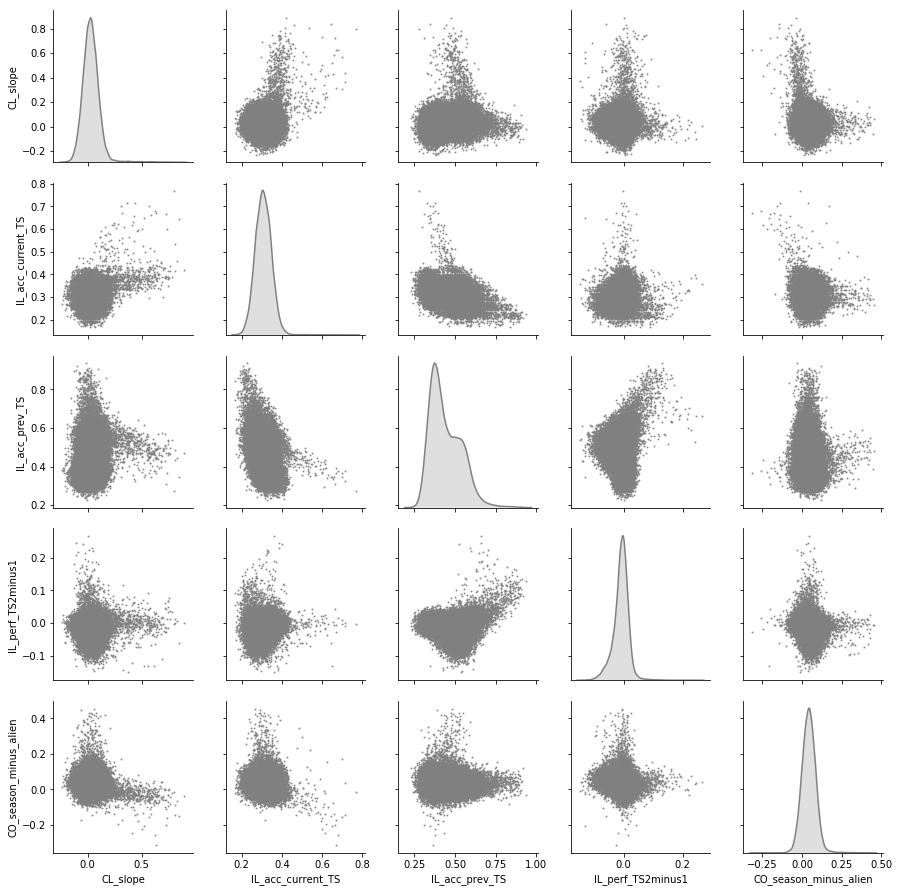

In [52]:
# Plot paramter - marker correlations
hum_sums = hum_summary_initial_learn[['IL_acc_prev_TS', 'IL_acc_current_TS', 'IL_perf_TS2minus1']]
hum_sums['CL_slope'] = hum_summary_cloudy['CL_slope']
hum_sums['CO_season_minus_alien'] = hum_summary_competition['CO_season_minus_alien']
markers = ['CL_slope', 'IL_acc_current_TS', 'IL_acc_prev_TS', 'IL_perf_TS2minus1', 'CO_season_minus_alien']

for model, params in zip(models, [param_names[:3], param_names]):

    # Correlations between markers and parameters
    dat = all_summaries.loc[all_summaries['model'] == model]
    sns.pairplot(dat, x_vars=params, y_vars=markers, kind='reg',
             plot_kws={'color': 'grey', 'fit_reg': False, 'scatter_kws': {'s': 1}})
    plt.savefig(plot_save_dir + '/CorrMarkerParam_' + model + '.png')

    # Correlations between different markers
    sns.pairplot(dat, vars=markers, kind='reg',
                 plot_kws={'color': 'grey', 'fit_reg': False, 'scatter_kws': {'s': 1}},
                 diag_kind='kde', diag_kws={'color': 'grey', 'shade': True})
    # add human data
    # plt.scatter(hum_sums)
    plt.savefig(plot_save_dir + '/CorrParamParam_' + model + '.png')

Saving selected_agents to C:/Users/maria/MEGAsync/Berkeley/TaskSets/AliensFitting/SummariesInsteadOfFitting_revision/selected_agents.csv


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


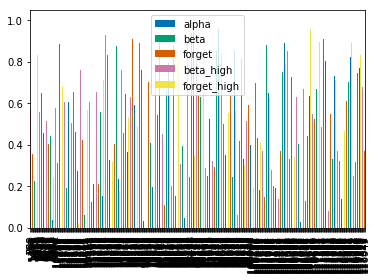

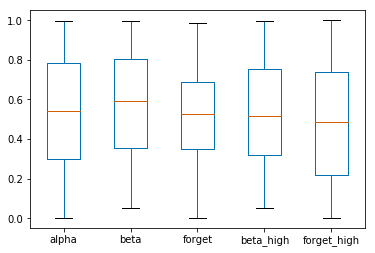

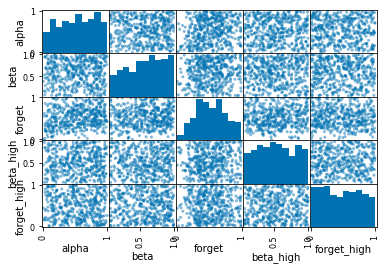

In [54]:
# Find a good subset of parameters - define criteria
IL_acc_prev_TS = (
        all_summaries['IL_acc_prev_TS'] > 3/4 * hum_summary_initial_learn['IL_acc_prev_TS'].values[0]) & (
        all_summaries['IL_acc_prev_TS'] < 3/2 * hum_summary_initial_learn['IL_acc_prev_TS'].values[0])
IL_perf_TS2minus1 = (
        all_summaries['IL_perf_TS2minus1'] < 3/4 * hum_summary_initial_learn['IL_perf_TS2minus1'].values[0]) & (
        all_summaries['IL_perf_TS2minus1'] > 3/2 * hum_summary_initial_learn['IL_perf_TS2minus1'].values[0])
CL_slope = (
        all_summaries['CL_slope'] > 3/4 * hum_summary_cloudy['CL_slope'].values[0]) & (
        all_summaries['CL_slope'] < 3/2 * hum_summary_cloudy['CL_slope'].values[0])
CO_season_minus_alien = (
       all_summaries['CO_season_minus_alien'] > 3/4 * hum_summary_competition['CO_season_minus_alien'].values[0]) & (
       all_summaries['CO_season_minus_alien'] < 3/2 * hum_summary_competition['CO_season_minus_alien'].values[0])
# RB_TS2minusTS0 = rainbow_dat['TS2minutsTS0']

# Subset data and plot
selected_agents = all_summaries.loc[
    IL_acc_prev_TS & IL_perf_TS2minus1 & CL_slope & CO_season_minus_alien]
# Save selected_agents as csv
if do_save_selected_agents:
    save_path = plot_dir + '/selected_agents.csv'
    print("Saving selected_agents to {}".format(save_path))
    selected_agents.to_csv(save_path, index=False)

selected_agents[['beta', 'beta_high']] /= 20
selected_agents[param_names].plot(kind='bar')
selected_agents[param_names].plot(kind='box', by='model')
scatter_matrix(selected_agents[param_names])
plt.show()

# Nice looking agent: selected_agents.loc[129534, param_names]

NameError: name 'do_isomap' is not defined

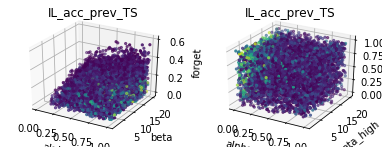

In [55]:
# Intrusion error heatmap (prev_TS)
fig = plt.figure(figsize=(10, 5))
for i, effect in enumerate(['IL_acc_prev_TS', 'IL_acc_current_TS']):

    # Subset data with human-like behavior
    dat = all_summaries.loc[(all_summaries['model'] == 'hier') &
                            (all_summaries['IL_acc_prev_TS'] > 0.55)]

    # Plot raw parameters
    ax = fig.add_subplot(2, 3, (i*3)+1, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha'], dat['beta'], dat['forget'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.set_zlabel('forget')

    ax = fig.add_subplot(2, 3, (i*3)+2, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha_high'], dat['beta_high'], dat['forget_high'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha_high')
    ax.set_ylabel('beta_high')
    ax.set_zlabel('forget_high')

    if do_isomap:
        # Dimensionality reduction
        n_neighbors = 12
        n_components = 3
        params_norm = preprocessing.StandardScaler().fit_transform(dat[param_names])  # standardize data
        Y = manifold.Isomap(n_neighbors, n_components).fit_transform(params_norm)  # apply Isomap

        # Plot dimensionality-reduced parameters
        ax = fig.add_subplot(2, 3, (i*3)+3, projection='3d')
        ax.set_title("Isomap " + effect)
        ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=dat[effect], marker='.')

    plt.tight_layout()
plt.show()

In [ ]:
# # Calculate Isomap & Co. and visualize
# params_norm = preprocessing.StandardScaler().fit_transform(dat[param_names])  # standardize data
# effect = dat['IL_acc_prev_TS']
# fig = plt.figure(figsize=(15, 5))
#
# i = 1
# for n_components in range(2, 6, 2):
#     for n_neighbors in range(2, 20, 3):
#
#         # Reduce dimensionality
#         # Y = decomposition.PCA(n_components).fit_transform(params_norm)
#         # mds = manifold.MDS(n_neighbors, max_iter=100, n_init=1)
#         # Y = mds.fit_transform(params_norm)
#         # Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components, eigen_solver='auto',
#         #                                     method='standard').fit_transform(params_norm)
#         # Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components, eigen_solver='auto',  # n_neighbors >= 6
#         #                                     method='modified').fit_transform(params_norm)
#         Y = manifold.Isomap(n_neighbors, n_components).fit_transform(params_norm)
#
#         # Plot
#         ax = fig.add_subplot(2, 6, i)
#         plt.scatter(Y[:, 0], Y[:, 1], c=effect)
#         plt.title('{0} comp., {1} neigh.'.format(n_components, n_neighbors))
#         i += 1
# plt.tight_layout()
# plt.show()

# Intrusion error heatmap (other TS)
fig = plt.figure()
for i, effect in enumerate(['IL_acc_other_TS', 'IL_acc_current_TS']):

    dat = all_summaries.loc[(all_summaries['model'] == 'hier') &
                            (all_summaries['IL_acc_other_TS'] > 1/3)]

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha'], dat['beta'], dat['forget'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.set_zlabel('forget')

    ax = fig.add_subplot(2, 2, i+3, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha_high'], dat['beta_high'], dat['forget_high'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha_high')
    ax.set_ylabel('beta_high')
    ax.set_zlabel('forget_high')
plt.tight_layout()

# Savings heatmap
fig = plt.figure()
for i, effect in enumerate(['IL_saving_av', 'IL_saving_first_trial', 'IL_saving_last_trial', 'IL_saving_last_minus_first']):

    dat = all_summaries.loc[(all_summaries['model'] == 'hier') &
                            (all_summaries['IL_saving_last_trial'] > 0.01) & (all_summaries['IL_saving_first_trial'] > 0.08)]

    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha'], dat['beta'], dat['forget'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.set_zlabel('forget')

    ax = fig.add_subplot(2, 4, i+5, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha_high'], dat['beta_high'], dat['forget_high'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha_high')
    ax.set_ylabel('beta_high')
    ax.set_zlabel('forget_high')
plt.tight_layout()

# Cloudy heatmap
fig = plt.figure()
for i, effect in enumerate(['CL_acc_trial2', 'CL_acc_trial3']):

    dat = all_summaries.loc[(all_summaries['model'] == 'hier') &
                            (all_summaries['CL_acc_trial2'] > 0.4) & (all_summaries['CL_acc_trial3'] > 0.4)]

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha'], dat['beta'], dat['forget'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.set_zlabel('forget')

    ax = fig.add_subplot(2, 2, i+3, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha_high'], dat['beta_high'], dat['forget_high'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha_high')
    ax.set_ylabel('beta_high')
    ax.set_zlabel('forget_high')
plt.tight_layout()

# Competition heatmap
fig = plt.figure()
for i, effect in enumerate(['CO_acc_season', 'CO_acc_season_alien']):

    dat = all_summaries.loc[(all_summaries['model'] == 'hier') &
                            (all_summaries['CO_acc_season'] > 0.65)]  #  &(all_summaries['CO_acc_season_alien'] > 0.60)

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha'], dat['beta'], dat['forget'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.set_zlabel('forget')

    ax = fig.add_subplot(2, 2, i+3, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha_high'], dat['beta_high'], dat['forget_high'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha_high')
    ax.set_ylabel('beta_high')
    ax.set_zlabel('forget_high')
plt.tight_layout()

# Rainbow heatmap
fig = plt.figure()
for i, effect in enumerate(['RB_choices_TS0', 'RB_choices_TS1', 'RB_choices_TS2']):

    dat = all_summaries.loc[(all_summaries['model'] == 'hier') &
                            (all_summaries['RB_choices_TS0'] > 1300) & (all_summaries['RB_choices_TS1'] > 1000)]

    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha'], dat['beta'], dat['forget'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.set_zlabel('forget')

    ax = fig.add_subplot(2, 3, i+4, projection='3d')
    ax.set_title(effect)
    ax.scatter(dat['alpha_high'], dat['beta_high'], dat['forget_high'], c=dat[effect], label=dat[effect], marker='.')
    ax.set_xlabel('alpha_high')
    ax.set_ylabel('beta_high')
    ax.set_zlabel('forget_high')
plt.tight_layout()

# Plot overall heatmaps -> systematicity between parameters & effects?
for effect in summary_dat_cols:
    fig = plt.figure()
    plt.title(effect)
    for i, model in enumerate(models):
        dat = all_summaries.loc[all_summaries['model'] == model][:1000].copy()

        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        ax.scatter(dat['alpha'], dat['beta'], dat['forget'], c=dat[effect], label=dat[effect], marker='.')
        ax.set_title(model)
        ax.set_xlabel('alpha')
        ax.set_ylabel('beta')
        ax.set_zlabel('forget')

        ax = fig.add_subplot(2, 2, i+3, projection='3d')
        ax.scatter(dat['alpha_high'], dat['beta_high'], dat['forget_high'], c=dat[effect], label=dat[effect], marker='.')
        ax.set_xlabel('alpha_high')
        ax.set_ylabel('beta_high')
        ax.set_zlabel('forget_high')
    plt.tight_layout()

# Plot average effects for hierarchical and flat
fig = plt.figure()
ax = fig.add_subplot(111)

for i, model in enumerate(models):
    dat = all_summaries.loc[all_summaries['model'] == model].copy()
    RB_effects = [effect for effect in all_summaries.columns.values if 'RB' in effect]

    dat[RB_effects] /= 1000
    dat['beta'] /= 10
    x = np.arange(len(summary_dat_cols)) + 0.2 * (2*i-1)
    y = np.mean(dat[summary_dat_cols], axis=0)
    yerr = np.std(dat[summary_dat_cols], axis=0) / np.sqrt(len(summary_dat_cols))

    ax.bar(x, y.values, 0.4, yerr=yerr, label=model)
ax.set_xticks(np.arange(len(summary_dat_cols)))
ax.set_xticklabels(summary_dat_cols)
plt.xticks(rotation=20)
plt.ylabel('Effect (RB /= 1000)')
plt.legend()



stop = 3


## Plot bar graphs for humans and agents

In [ ]:
# Plot human behavior & selected_agents
def make_plot(hum_mean, ag_mean, hum_se=False, ag_se=False, plot_name="plot.png", ylabel="",
              hline=False, ylim=False, xlabel="", xticklabels=False, figsize=(8,4)):

    if not np.any(hum_se):
        hum_se = np.zeros(len(hum_mean.T))
    if not np.any(ag_se):
        ag_se = np.zeros(len(ag_mean.T))
    if not xticklabels:
        xticklabels = ""

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    [ax.set_title(title) for ax, title in zip(axes, ['Humans', 'Simulations'])]

    axes[0].bar(range(len(hum_mean)), hum_mean, yerr=hum_se, tick_label=xticklabels, color='grey')
    axes[1].bar(range(len(ag_mean)), ag_mean, yerr=ag_se, tick_label=xticklabels, color='grey')

    [ax.set_ylabel(ylabel) for ax in axes]
    [ax.set_xlabel(xlabel) for ax in axes]

    if ylim:
        [ax.set_ylim(ylim) for ax in axes]
    if hline:
        [ax.axhline(y=hline, color='black', linestyle='--') for ax in axes]

    plt.tight_layout()
    plt.savefig(plot_save_dir + plot_name)

In [ ]:
# Get agent data
selected_agents = pd.read_csv(plot_dir + '/rerun_selected_agents.csv', index_col=0)
ag_summary = selected_agents.loc[0]  # 0, 5, 6
print(pd.DataFrame(ag_summary).T)
# save_dir = plot_dir + 'ag_summary_for_paper.csv'
# ag_summary.to_csv(save_dir)
# print("Saving agent used for paper plots to {}!".format(save_dir))
# ag_summary = np.mean(selected_agents.loc[[0, 5, 6]], axis=0)

In [ ]:
ag_rainbow_dat = ag_summary[RB_cols].values.reshape((n_aliens, n_actions))
ag_summary_rainbow = get_summary_rainbow(n_aliens, n_seasons, ag_rainbow_dat, task)
ag_summary_rainbow = pd.DataFrame(np.expand_dims(ag_summary_rainbow, axis=0),
                                   columns=RB_sum_cols)
ag_summary_rainbow['TS2minusTS1'] = ag_summary_rainbow['TS2'] - ag_summary_rainbow['TS1']
ag_summary_rainbow

In [ ]:
# Double-check selected hier-agent summary
# plot_dir_ag = os.path.join(get_alien_paths(run_on_cluster)['fitting results'], 'SummariesInsteadOfFitting')  # Where will the simulated summary data be saved and read from?
params = pd.read_csv(plot_dir + '/ag_summary_for_paper.csv', index_col=0).loc[param_names]
params_01 = params.values.flatten() / (param_ranges.loc[1] - param_ranges.loc[0]) - param_ranges.loc[0] / (
            param_ranges.loc[1] - param_ranges.loc[0])
# params_back = param_ranges.loc[0] + (param_ranges.loc[1] - param_ranges.loc[0]) * params_01  # making sure i'm getting the right parameters back after transformation!

summary = get_summary(params_01.values.flatten(), param_ranges, n_sim, n_subj)
summary = pd.DataFrame(summary, index=summary_dat_cols).transpose()

summary  # check that it agrees with what we have in the paper! (This is just to double-check that I'm using the right parameters for the simulations!

In [ ]:
# Plot intrusion errors
make_plot(hum_summary_initial_learn[IL_cols[3:5]].values.flatten(), ag_summary[IL_cols[3:5]].values.flatten(),
          hum_summary_initial_learn[IL_cols[6:8]].values.flatten(), ag_summary[IL_cols[6:8]].values.flatten(),
          plot_name='1intrusion_errors.png', figsize=(4, 4),
          ylabel="Fraction (trial 1)", hline=1/3, ylim=(0, 0.5), xticklabels=['Acc.', 'Intr.err.'])

# Plot TS values affect performance
make_plot(hum_summary_initial_learn[IL_cols[10:12]].values.flatten(), ag_summary[IL_cols[10:12]].values.flatten(),
          hum_summary_initial_learn[IL_cols[13:15]].values.flatten(), ag_summary[IL_cols[13:15]].values.flatten(),
          plot_name='2TS_values_perf.png.', figsize=(4, 4),
          ylabel="TS performance", hline=1/3, ylim=(1/3, 0.65), xticklabels=['TS2', 'TS1'])

# Plot Savings
make_plot(hum_summary_initial_learn[IL_cols[:3]].values.flatten(), ag_summary[IL_cols[:3]].values.flatten(),
          plot_name='5Savings.png', figsize=(6, 4),
          ylabel="Savings", xticklabels=IL_cols[:3])

In [ ]:
# Plot TS reactivation
make_plot(hum_summary_cloudy[CL_cols[:4]].values.flatten(), ag_summary[CL_cols[:4]].values.flatten(),
          hum_summary_cloudy[CL_cols[4:8]].values.flatten(), ag_summary[CL_cols[4:8]].values.flatten(),
          plot_name='0TS_react.png',
          ylabel="% correct", hline=False, ylim=(0, 0.45),
          xlabel="Trial", xticklabels=range(1, n_aliens+1))

In [ ]:
# TS values affect preference
make_plot(hum_summary_competition[CO_cols[:2]].values.flatten(), ag_summary[CO_cols[:2]].values.flatten(),
          hum_summary_competition[CO_cols[2:4]].values.flatten(),
          plot_name='3TS_values_preference.png', figsize=(4, 4),
          ylabel="frac. better chosen", hline=1/2, ylim=(0, 0.65), xticklabels=['Context', 'Stimulus'])

In [ ]:
# Plot TS values affect generalization
make_plot(hum_summary_rainbow[RB_sum_cols[:4]].values.flatten(), ag_summary_rainbow[RB_sum_cols[:4]].values.flatten(),
          hum_summary_rainbow[RB_sum_cols[4:8]].values.flatten(),
          plot_name='4TS_values_generalization.png',
          ylabel='% TS selected', ylim=(0, 0.45), xticklabels=['TS3', 'TS2', 'TS1', 'No-TS'])

In [ ]:
# Rainbow phase correlation between human and simulated actions
rb_cor = np.corrcoef(hum_rainbow_dat[0].flatten(), ag_rainbow_dat.astype(float).flatten())[0, 1]
stats.pearsonr(hum_rainbow_dat[0].flatten(), ag_rainbow_dat.astype(float).flatten())

# Rainbow phase action heatmaps
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
plt.suptitle('Correlation between humans & simulation: {}'.format(rb_cor.round(3)))
[ax.set_title(title) for ax, title in zip(axes, ['Humans', 'Simulations'])]
cax1 = axes[0].matshow(hum_rainbow_dat[0])
axes[1].matshow(ag_rainbow_dat.astype(float))
[ax.set_xlabel('Action') for ax in axes]
[ax.set_ylabel('Stimulus') for ax in axes]
# fig.colorbar(cax1)

# # Show values of correct actions in rainbow phase
# correct_TS = task.TS.copy().astype(float)
# correct_TS[correct_TS == 1] = np.nan
# av_Q_correct_action = np.nanmean(correct_TS, axis=0)
# av_Q_correct_action[np.isnan(av_Q_correct_action)] = 0
# axes[1].set_title("Values correct actions")
# axes[1].matshow(av_Q_correct_action)
# for (i, j), z in np.ndenumerate(av_Q_correct_action):
#     axes[1].text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
# axes[0].set_xlabel('Aliens')
# axes[0].set_ylabel('Actions')